# Cat vs Dog Classification

![Cat-vs-Dog](https://www.researchgate.net/profile/Atul-Sharma-77/publication/353247632/figure/fig2/AS:1045582240026626@1626297640509/Classification-of-two-classes-dog-and-cat-using-CNN.jpg)

## 목표 : 주어진 사진이 Cat vs Dog 중 어떤 사진인지 분류할 수 있는 모델을 만들기

## 데이터셋 : Kaggle Cat and Dog 데이터셋을 활용해보기
[Kaggle Cat and Dog](https://www.kaggle.com/datasets/tongpython/cat-and-dog/)

---

- Kaggle이란?
  - Kaggle는 2010년에 설립된 예측모델 및 분석 대회 플랫폼으로, 기업이나 단체들이 데이터와 해결 과제를 등록하고 데이터 과학자들이 이를 해결하기 위한 모델을 개발하며 경쟁하는 플랫폼
  - Microsoft Kinect의 제스처 인식 개선, Manchester City의 축구 AI 만들기, Two Sigma Investments를 위한 거래 알고리즘 코딩, CERN에서의 힉스 보손 탐색 개선 등 다양한 대회를 개최하고 있음
  - 2017년 구글에 인수, 194개국에 걸쳐 2023년 10월 기준으로 1500만 명이 넘는 등록 사용자를 보유

In [ ]:
#@title 라이브러리 Import

import os
import glob

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from torchsummary import summary

In [ ]:
#@title Google Drive 연결

# Google Drive를 마운트하기
import os, errno
from google.colab import drive

def symlink_force(target, link_name):
    try:
        os.symlink(target, link_name)
    except OSError as e:
        if e.errno == errno.EEXIST:
            os.remove(link_name)
            os.symlink(target, link_name)
        else:
            raise e

drive.mount('/content/drive', force_remount=True)

#@markdown ### Google Drive 경로 지정
folder_path = "ETRI SW-SoC" #@param {type:"string"}

# 심볼릭 링크 생성을 통해 특정 폴더 연동
symlink_force(f'/content/drive/My Drive/{folder_path}', '/content/gdrive')

Mounted at /content/drive


In [ ]:
#@title [Optional] Google Drive 에서 Colab 환경으로 데이터 복사
!cp -rf 'gdrive/dataset/cat-vs-dog' 'cat-vs-dog'

In [ ]:
#@title 데이터 폴더 확인 및 데이터 파일 목록 생성

#base_dir = 'gdrive/dataset/cat-vs-dog'
base_dir = 'cat-vs-dog'

train_dir = base_dir + '/training_set'
test_dir = base_dir + '/test_set'
print(os.listdir(train_dir))

train_list = glob.glob(os.path.join(train_dir, 'dogs/*.jpg')) + glob.glob(os.path.join(train_dir, 'cats/*.jpg'))
val_list = glob.glob(os.path.join(test_dir, 'dogs/*.jpg')) + glob.glob(os.path.join(test_dir, 'cats/*.jpg'))
print(train_list[:5])
print(len(train_list))

['cats', 'dogs']
['cat-vs-dog/training_set/dogs/dog.768.jpg', 'cat-vs-dog/training_set/dogs/dog.3223.jpg', 'cat-vs-dog/training_set/dogs/dog.3597.jpg', 'cat-vs-dog/training_set/dogs/dog.3522.jpg', 'cat-vs-dog/training_set/dogs/dog.1353.jpg']
8005


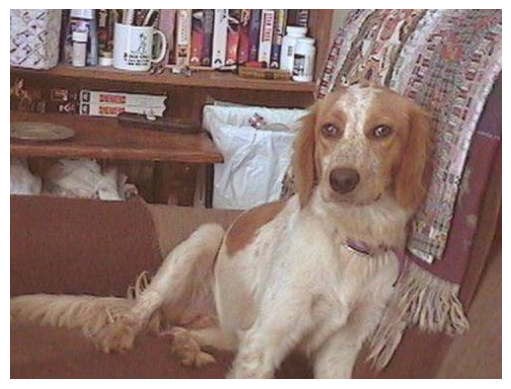

In [ ]:
img = Image.open(train_list[0])
#img = Image.open(train_list[-10])
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#@title 데이터 변환 및 증강

class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
#@title 데이터셋 및 데이터 로더

class DogvsCatDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        img_path = self.file_list[idx]
        img = Image.open(img_path)

        img = self.transform(img, self.phase)

        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img, label

## VGG16 Model Architecture

![VGG16](https://github.com/jphan32/CVTrack-Tutorials/blob/main/resources/vgg16.png?raw=true)

```
VGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer7): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer8): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer9): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer10): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer11): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer12): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (layer13): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=25088, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=4096, out_features=2, bias=True)
  )
)
```

In [ ]:
#@title 모델

class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
#@title Config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 64
num_epoch = 10

In [ ]:
train_dataset = DogvsCatDataset(train_list, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_list, transform=ImageTransform(size, mean, std), phase='val')

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
#model = VGG16(num_classes=2).to(device)
#summary(model, (3, 224, 224))

model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
print(model)

params_to_update = []
for name, param in model.named_parameters() :
    if name.startswith('classifier.6') :
        param.requires_grad = True
        params_to_update.append(param)
    else :
        param.requires_grad = False

model = model.to(device)
summary(model, (3, 224, 224))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [ ]:
for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch + 1, num_epoch))
    print('-'*20)

    model.train()

    epoch_loss = 0.0
    epoch_corrects = 0

    for inputs, labels in tqdm(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()

      optimizer.step()

      epoch_loss += loss.item()
      #epoch_corrects += torch.sum(outputs==labels)

    epoch_loss = epoch_loss / len(train_dataloader)
    #epoch_acc = epoch_corrects / len(train_dataloader)
    print(f"loss: {epoch_loss}")

Epoch 1/10
--------------------


  0%|          | 0/126 [00:00<?, ?it/s]

loss: 0.06362874791144378
Epoch 2/10
--------------------


  0%|          | 0/126 [00:00<?, ?it/s]

loss: 0.044059175062030255
Epoch 3/10
--------------------


  0%|          | 0/126 [00:00<?, ?it/s]

loss: 0.042191469007992144
Epoch 4/10
--------------------


  0%|          | 0/126 [00:00<?, ?it/s]

loss: 0.039978948183402065
Epoch 5/10
--------------------


  0%|          | 0/126 [00:00<?, ?it/s]

loss: 0.0393562403222036
Epoch 6/10
--------------------


  0%|          | 0/126 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

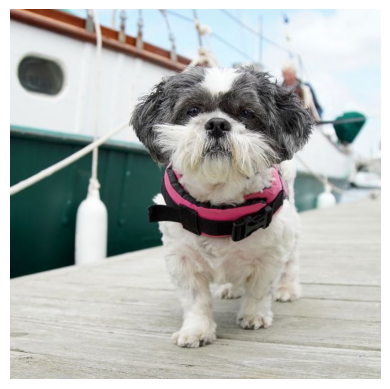

In [ ]:
img = Image.open('test.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:

img = Image.open('test2.jpg')
tr = ImageTransform(size, mean, std)
img = tr(img, 'val')
img = img.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
  output = model(img)
  print(output)

tensor([[ 5.4612, -4.7824]], device='cuda:0')
